# DoA of ULA
This notebook reviews Direction of Arrival (DoA) methods for Uniform Linear Arrays (ULA).
The DoA methods considered here include FFT Beamforming and MUSIC (MUltiple SIgnal Classification).
The FMCW-MIMO radar considered here operates in the 77 GHz frequency band.

First, we define a coordinate system similar to the one in the [previous notebook](./01_beam_pattern.ipynb).

<img src="../images/01_coordinate_system_of_ULA.svg" width="600" style="background-color: white;">

The following implementation synthesizes the Intermediate Frequency (IF) signal for an 8-element ULA FMCW-MIMO radar.
The ULA is configured as a 1TX 8RX MIMO system, and the chirp parameters are set for an Ultra Short Range Radar (USRR).
The MIMO configuration and chirp settings are specified in `MIMOConfiguration` and `ChirpConfiguration`, respectively.
| Parameter| USRR |
| ---- | ---- |
| start frequency [GHz]| 76.8 |
| chirp duration [us]| 30 |
| number of samples per chirp | 250 |
| number of chirps | 128 |
| ramp slope [MHz/us]| 30  |

For more details on USRR configuration, refer to [Programming Chirp Parameters in TI Radar Devices](https://www.ti.com/lit/an/swra553a/swra553a.pdf) published by Texas Instruments.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from radar_simulation import ChirpConfiguration
from radar_simulation import MIMOConfiguration
from radar_simulation import FMCWMIMORadar
from radar_simulation import TargetObject
from signal_processing import RangeDopplerFFT
from signal_processing import BeamFormingDOA
from signal_processing import MUSIC
from sensor import MIMOVirtualArray

In [ ]:
# (0) setup
# (0.1) 8-ULA
num_tx = 1
num_rx = 8
txl = np.zeros((num_tx, 3))
txl[0, 0] = 0
rxl = np.zeros((num_rx, 3))
rxl[:,0] = np.arange(num_rx)
# (0.1) configuration
cc = ChirpConfiguration()
mc = MIMOConfiguration(txl, rxl, cc.start_lambda, 0.5)
radar = FMCWMIMORadar(cc, mc)
mva = MIMOVirtualArray(mc)
# (0.2) object
objs = list()
objs.append(TargetObject(7, 1, -10))
objs.append(TargetObject(17, -2, 10))

Two objects with different speeds and initial positions are set up.
The speed is given as a radial velocity, and the initial position is specified in polar coordinates.
The target objects are defined as a list of `TargetObject` class instances.
| Parameter| Object #1 | Object #2 |
| ---- | ---- | ---- |
| range [m] | 7 | 17 |
| $\theta$ [deg]| -10 | 10|
| radial velocity [m/s] | 1 | -2 |

Object #1, which is closer and on the left, is set to move away, while Object #2, farther away and on the right, is set to approach.

By passing the number of frames and the objects to the `get_data_cube` method of the `FMCWMIMORadar` class, a 4D data cube can be obtained.
Noise can be added to the 4D data cube as needed.

In [ ]:
# (1) do simulation
num_frames = 10
dc = radar.get_data_cube(num_frames, objs)

The signal processing for the 4D data cube is implemented minimally.
The `RangeDopplerFFT` class implements 1D and 2D FFT to obtain the range-Doppler map.
The range-Doppler map is obtained by applying a 2D FFT, then converting the MIMO power to decibels (dB), and finally averaging over the MIMO channels.

Text(0.5, 0, 'Range [m]')

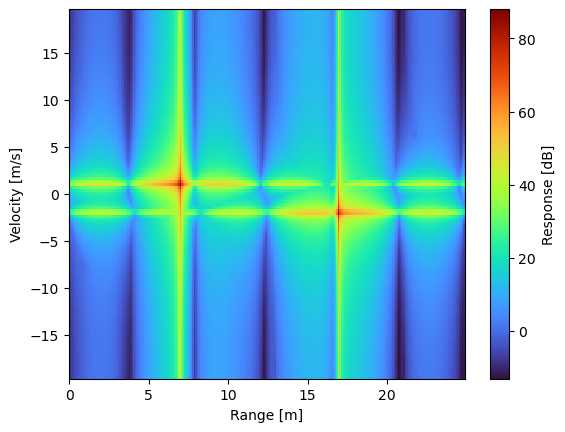

In [ ]:
postproc = RangeDopplerFFT()
rdm = postproc.get_2d_fft(dc)

target_frame = 0
rdm0_dB = np.mean(20 * np.log10((np.abs(rdm[target_frame,:,:,:,:]))), (1, 0))

range_bin = postproc.get_range_bins(cc)
velocity_bin = postproc.get_velocity_bins(cc)

fig, ax = plt.subplots()
cm = ax.pcolor(range_bin, velocity_bin, rdm0_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_ylabel('Velocity [m/s]')
ax.set_xlabel('Range [m]')

Strong peaks can be observed at the points (range, velocity) = (7, 1) and (17, -2), where the objects exist.
In general, object detection on the range-Doppler map is carried out using methods such as CA-CFAR.
However, for simplicity in this case, objects are assumed to be detected at the local maxima near the strong peaks, and DoA estimation is then applied.

The `BeamFormingDOA` class implements FFT-based beamforming.

First, the angle spectrum for each object is computed.
The angle spectrum shows the signal power as a function of angle.
The main lobe corresponds to the direction of the strongest signal, usually indicating the true direction of arrival of a target.
Side lobes are smaller peaks that appear at other angles due to the finite size and spacing of the antenna array;
they are generally undesirable because they can cause false detections.
Nulls are points or regions in the angle spectrum where the response drops to nearly zero.

Second, the range-azimuth map is computed by first averaging over the Doppler dimension, then calculating the angle spectrum for each range bin using FFT-based Beamforming, and finally stacking these spectra together.
This process generates a two-dimensional map where one axis represents range and the other represents azimuth angle, allowing visualization of object positions in the range-angle plane.


In [ ]:
# in realistic case use somewhat detection method like the CFAR
d_range, d_doppler = (72, 174), (67, 57)

bf = BeamFormingDOA(mva)
angle_bins = bf.get_angle_bins()
angle_bins_degrees = np.rad2deg(angle_bins)

angle_spectrum = list()
for k, l in zip(d_range, d_doppler):
    signal = mva.get_signal(rdm[target_frame,:,:,l,k])
    s = bf.get_angle_fft(signal)
    angle_spectrum.append(s)

rm = postproc.get_1d_fft(dc)
ram = np.empty((rm.shape[4], bf.angle_fft_size), dtype=rm.dtype)
for k in range(ram.shape[0]):
    signal = mva.get_signal(rm[target_frame,:,:,:,k])
    signal = np.mean(signal, axis=-1)
    s = bf.get_angle_fft(signal)
    ram[k,:] = s

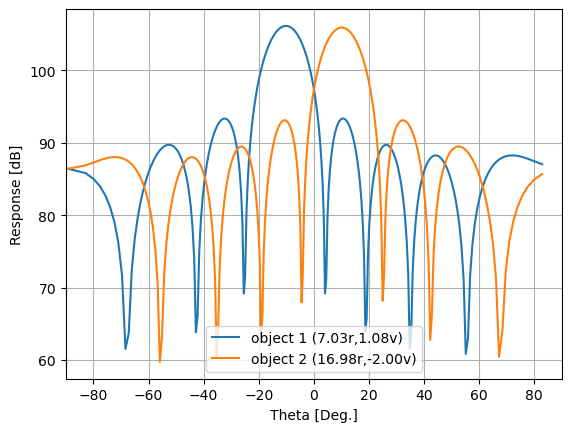

In [ ]:
angle_spectrum_power_dB = list()
for s in angle_spectrum:
    p = 20 * np.log10(np.abs(s))
    angle_spectrum_power_dB.append(p)

fig, ax = plt.subplots()
ax.set_ylabel('Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_xlim([-90, 90])
for k in range(len(angle_spectrum_power_dB)):
    l = 'object {} ({:.2f}r,{:.2f}v)'.format(k + 1, range_bin[d_range[k]], velocity_bin[d_doppler[k]])
    ax.plot(angle_bins_degrees, angle_spectrum_power_dB[k], label=l)
ax.grid()
ax.legend()

In the angle spectrum, a strong peak is observed at $\theta_0 = -10^\circ$ for the near object, and at $\theta_1 = 10^\circ$ for the far object.

Text(0, 0.5, 'Range [m]')

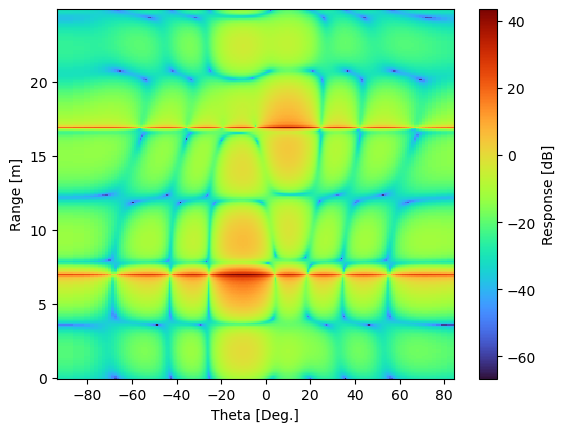

In [ ]:
ram_dB = 20 * np.log10(np.abs(ram))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_degrees, range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_ylabel('Range [m]')

In the range-azimuth map, both the main lobe and side lobes appear periodically.

The range-azimuth map can be displayed in polar coordinates, where the radial axis represents range (distance from the radar) and the angular axis represents the azimuth angle.
This type of visualization provides an intuitive way to understand the spatial distribution of detected objects, as their positions are shown according to their distance and direction from the radar.

Text(0, 0.5, 'Range [m]')

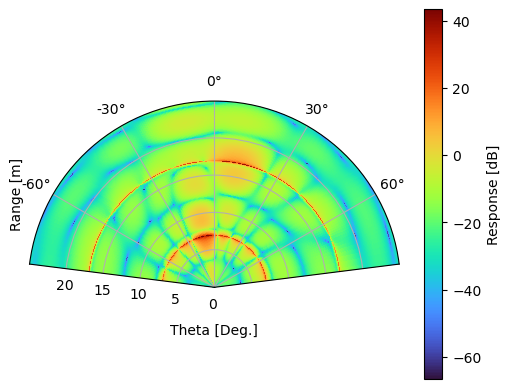

In [ ]:
lim_angle = np.max(angle_bins)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins, range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Theta [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')

Next, an implementation applying the MUSIC method to the same signal is shown.
The MUSIC method is a high-resolution DoA method.
It works by separating the signal and noise subspaces using the covariance matrix of the received signals, and identifies the angles where the steering vector is orthogonal to the noise subspace.
This results in sharp peaks at the true directions of arrival.

The `MUSIC` class implements a simple MUSIC method.
When the number of objects is unknown, the MUSIC algorithm generally needs to estimate the rank of the signal subspace.
The `MUSIC` class is designed to implement this rank estimation with a functor, but for simplicity, a dummy functor corresponding to the single-object case is used here.
As with beamforming, the MUSIC pseudo-spectrum and the range-azimuth map are computed in a similar way.

In [ ]:
rank_est_1 = lambda x:  1 # dummy functor
rank_est_0 = lambda x:  0 # dummy functor
mu1 = MUSIC(rank_est_1)
mu0 = MUSIC(rank_est_0)

rmm = np.empty((rm.shape[4], bf.angle_fft_size), dtype=rm.dtype) # range-music-map
steering = mva.get_steering_vector_matrix(angle_bins)

for k in range(rmm.shape[0]):
    signal = mva.get_signal(rm[target_frame,:,:,:,k])
    Rxx = np.dot(signal, signal.conj().T) / signal.shape[1]
    if k in d_range:
        rmm[k,:] = mu1.get_music_spetrum(Rxx, steering) # object is detected
    else:
        rmm[k,:] = mu0.get_music_spetrum(Rxx, steering) # object is not detected

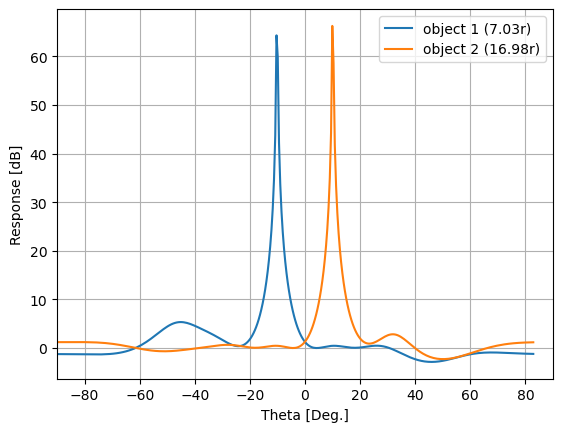

In [ ]:
# music-spectrum for detected object
music_spec = np.empty((len(d_range), angle_bins.shape[0]), dtype=signal.dtype)
for k, kk in zip(d_range, range(len(d_range))):
    music_spec[kk, :] = rmm[k, :]

music_spectrum_power_dB = list()
for s in music_spec:
    p = 20 * np.log10(np.abs(s))
    music_spectrum_power_dB.append(p)

fig, ax = plt.subplots()
ax.set_ylabel('Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_xlim([-90, 90])
for k in range(len(music_spectrum_power_dB)):
    l = 'object {} ({:.2f}r)'.format(k + 1, range_bin[d_range[k]])
    ax.plot(angle_bins_degrees, music_spectrum_power_dB[k], label=l)
ax.grid()
ax.legend()

In the MUSIC pseudo-spectrum, a strong peak is observed at $\theta_0 = -10^\circ$ for the near object, and at $\theta_1 = 10^\circ$ for the far object.
Compared to the angle spectrum obtained with beamforming, the MUSIC pseudo-spectrum exhibits much sharper and narrower peaks at the true directions of arrival.
Additionally, the side lobes in the MUSIC pseudo-spectrum are significantly lower and less pronounced than those in beamforming.

Text(0, 0.5, 'Range [m]')

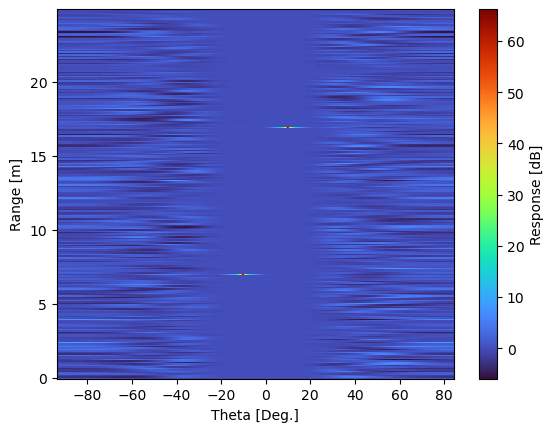

In [ ]:
rmm_dB = 20 * np.log10(np.abs(rmm))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_degrees, range_bin, rmm_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_ylabel('Range [m]')

Text(0, 0.5, 'Range [m]')

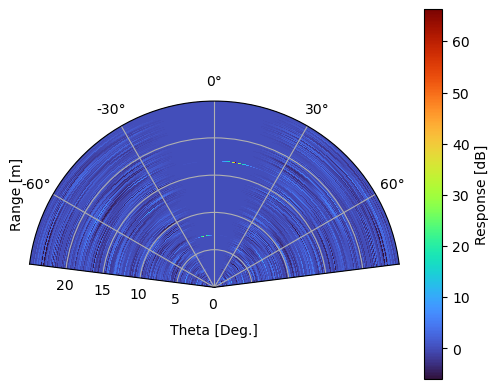

In [ ]:
lim_angle = np.max(angle_bins)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins, range_bin, rmm_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Theta [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')

This characteristic can also be observed in the range-azimuth map obtained by stacking the MUSIC pseudo-spectrum.